In [21]:
import torch 
import torch.nn as nn 
import torch.optim as optim 
from torch.utils.data import DataLoader,Dataset
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image
import torchvision.models as models
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F
import time
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix,accuracy_score
import seaborn as sns

In [2]:


Train_path = "/kaggle/input/brain-tumor/Preprocessed_Dataset/Training"
Test_path = "/kaggle/input/brain-tumor/Preprocessed_Dataset/Testing"

def creating_dataset(path_name):
    class_list = sorted(os.listdir(path_name))  # All tumor types (class)
    X = []
    y = []
    
    for tumor_type in class_list:
        tumor_path = os.path.join(path_name, tumor_type)
        
        for image in os.listdir(tumor_path):
            image_path = os.path.join(tumor_path, image)
            img = cv2.imread(image_path)  # Read image in BGR
            if img is None:
                continue  # Skip corrupt images
            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            X.append(img)
            y.append(class_list.index(tumor_type))  # Label index

    # Convert to PyTorch tensors
    X = torch.FloatTensor(np.array(X)).permute(0, 3, 1, 2) / 255.0  # (N, H, W, C) → (N, C, H, W)
    y = torch.LongTensor(y) 

    return X, y

# Load datasets
X_train, y_train = creating_dataset(Train_path)
X_test, y_test = creating_dataset(Test_path)

print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, Labels shape: {y_test.shape}")


Training data shape: torch.Size([5712, 3, 224, 224]), Labels shape: torch.Size([5712])
Testing data shape: torch.Size([1311, 3, 224, 224]), Labels shape: torch.Size([1311])


Train & validation split

In [3]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=1)

In [4]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([4569, 3, 224, 224])
torch.Size([1143, 3, 224, 224])
torch.Size([1311, 3, 224, 224])


In [5]:
# Transformation for data augmentation
transform = transforms.Compose([
    transforms.RandomRotation(10),        
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(256, scale=(0.95, 1.0)),
    transforms.ToTensor(),
])

In [6]:
class AugmentedDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = to_pil_image(self.images[idx])
        if self.transform:
            img = self.transform(img)  # Apply augmentation
        return img, self.labels[idx]

# Create dataset and DataLoader
aug_dataset = AugmentedDataset(X_train, y_train, transform=transform)
train_loader = DataLoader(aug_dataset, batch_size=32, shuffle=True)


In [7]:
class PrepareDataset(Dataset):
    def __init__(self,images,labels):
        self.images=images
        self.labels=labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        return self.images[index],self.labels[index]
    
val_dataset = PrepareDataset(X_val,y_val)
val_loader = DataLoader(val_dataset,batch_size=32,shuffle=False)

test_dataset = PrepareDataset(X_test,y_test)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=False)

Resnet-50 transfer learning model

In [8]:
class BrainTumorClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BrainTumorClassifier, self).__init__()
        # Load pre-trained ResNet-50 model with imagenet weights
        self.base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
                
        
        for param in self.base_model.parameters():
            param.requires_grad = True  # Unfreeze all layers for training

        # Replacing the final fully connected layer and adding a classification layer
        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(in_features, num_classes),  
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.base_model(x)

Train the model

In [14]:
def train_model(model, train_loader, val_loader, num_epochs=35, lr=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Lists to store metrics for plotting
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()  
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        val_acc, val_loss = evaluate_model(model, val_loader, criterion, device)

        # Store metrics for plotting
        train_losses.append(running_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.2f}% - "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Plot Training vs Validation Accuracy & Loss
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

    return model

Plot metrics for Training

In [15]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, save_path="plots"):
    """Function to plot accuracy and loss curves and save them as images."""
    os.makedirs(save_path, exist_ok=True)  # Create directory if it doesn't exist
    
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", marker='o')
    plt.plot(epochs, val_losses, label="Val Loss", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.savefig(f"{save_path}/loss_plot.png")  # Save loss plot

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Acc", marker='o')
    plt.plot(epochs, val_accuracies, label="Val Acc", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.savefig(f"{save_path}/accuracy_plot.png")  # Save accuracy plot

    plt.show()


Model evaluation

In [16]:
def evaluate_model(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    return accuracy, running_loss / len(loader)

Testing the model

In [17]:
def test_model(model, test_loader):
    """Evaluate the model on the test set and plot the confusion matrix."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    y_true, y_pred = [], []
    total_time = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            start_time = time.time()
            outputs = model(images)
            end_time = time.time()
            
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

            total_time += (end_time - start_time)

    # Compute Metrics
    test_acc = accuracy_score(y_true, y_pred) * 100
    precision = precision_score(y_true, y_pred, average="weighted") * 100
    recall = recall_score(y_true, y_pred, average="weighted") * 100
    f1 = f1_score(y_true, y_pred, average="weighted") * 100
    avg_inference_time = total_time / len(test_loader.dataset)

    print(f"Test Accuracy: {test_acc:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall: {recall:.2f}%")
    print(f"F1 Score: {f1:.2f}%")
    print(f"Avg Inference Time per Image: {avg_inference_time:.6f} sec")

    # Plot Confusion Matrix
    plot_confusion_matrix(y_true, y_pred)


def plot_confusion_matrix(y_true, y_pred , save_path="plots/confusion_matrix.png"):
    """Plot the confusion matrix using Seaborn."""
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=set(y_true), yticklabels=set(y_true))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig(save_path)
    plt.show()


Start model training

Epoch [1/42] - Train Loss: 0.8673, Train Acc: 89.12% - Val Loss: 0.8309, Val Acc: 91.69%
Epoch [2/42] - Train Loss: 0.7927, Train Acc: 95.47% - Val Loss: 0.7906, Val Acc: 95.54%
Epoch [3/42] - Train Loss: 0.7787, Train Acc: 96.83% - Val Loss: 0.7867, Val Acc: 95.54%
Epoch [4/42] - Train Loss: 0.7767, Train Acc: 96.89% - Val Loss: 0.7998, Val Acc: 94.66%
Epoch [5/42] - Train Loss: 0.7716, Train Acc: 97.64% - Val Loss: 0.8152, Val Acc: 93.00%
Epoch [6/42] - Train Loss: 0.7665, Train Acc: 97.96% - Val Loss: 0.7825, Val Acc: 96.33%
Epoch [7/42] - Train Loss: 0.7659, Train Acc: 97.94% - Val Loss: 0.7786, Val Acc: 96.59%
Epoch [8/42] - Train Loss: 0.7641, Train Acc: 98.05% - Val Loss: 0.7784, Val Acc: 96.41%
Epoch [9/42] - Train Loss: 0.7609, Train Acc: 98.38% - Val Loss: 0.7789, Val Acc: 96.59%
Epoch [10/42] - Train Loss: 0.7568, Train Acc: 98.84% - Val Loss: 0.7889, Val Acc: 95.54%
Epoch [11/42] - Train Loss: 0.7558, Train Acc: 98.99% - Val Loss: 0.7678, Val Acc: 97.64%
Epoch [12/42] - Tra

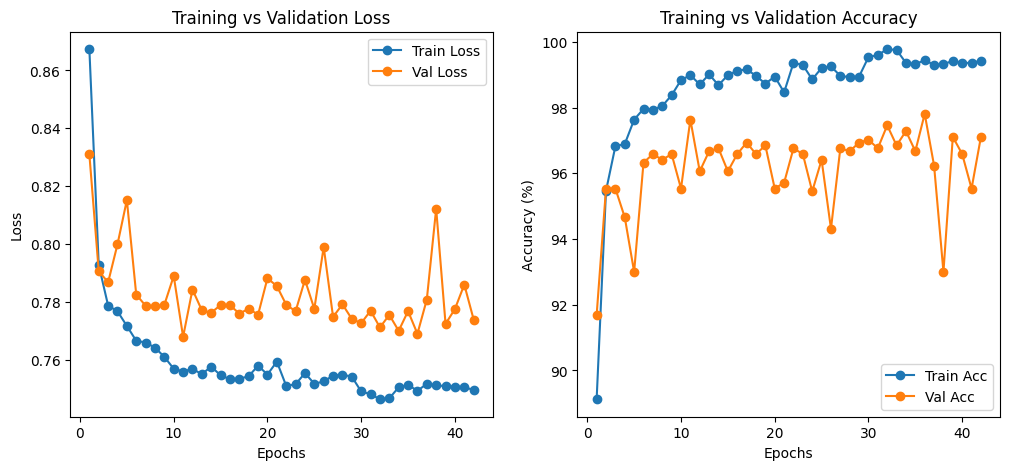

In [18]:
num_classes = len(set(y_train.numpy()))  # Get number of unique classes
model = BrainTumorClassifier(num_classes)

# Train model
model = train_model(model, train_loader, val_loader, num_epochs=42, lr=1e-4)

Save the model for further use.

In [19]:
model_save_path = "brain_tumor_classifier.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to brain_tumor_classifier.pth


Test Accuracy: 97.56%
Precision: 97.68%
Recall: 97.56%
F1 Score: 97.58%
Avg Inference Time per Image: 0.000209 sec


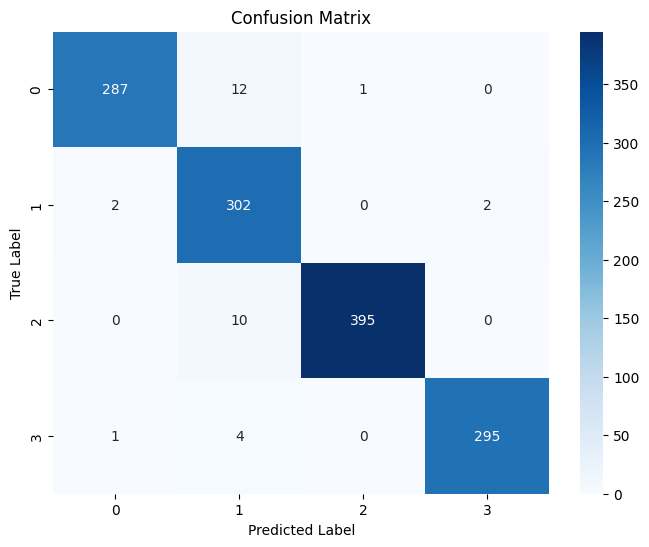

In [22]:
# Test model
test_model(model, test_loader)